### [Gradient Boosted Decision Trees](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees)

- Gradient Tree Boosting, aka Gradient Boosted Decision Trees (GBDT), is a generalization of boosting to **arbitrary differentiable loss functions**. GBDT is an excellent model for regression and classification - **especially for tabular data**.

- Scikit-learn provides __histogram__- and __gradient__-based classifiers & regressors.

### [Histogram-based Boosting](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting)
- Introduced in Scikit 0.21

- Inspired by [LightGBM](https://github.com/Microsoft/LightGBM)

- These histogram-based estimators can be __orders of magnitude faster__ than Gradient-based equivalents when the #samples is larger than tens of thousands of samples.

- They also have __built-in support for missing values__, which avoids the need for an imputer.

- These estimators bin the input samples X into integer-valued bins (typically 256 bins), which reduces the number of splitting points, and allows the algorithm to use integer-based data structures (histograms) instead of sorted continuous values when building the trees.

- The API of these estimators is slightly different, and some of the features from GradientBoostingClassifier and GradientBoostingRegressor are not yet supported, for instance some loss functions.

In [1]:
# usage: Most params are unchanged from GradientBoostingClassifier and GradientBoostingRegressor. 
# One exception: max_iter replaces n_estimators. It controls #iterations of the boosting algo.

from sklearn.ensemble import HistGradientBoostingClassifier as HGBC
from sklearn.datasets import make_hastie_10_2

X, y            = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = HGBC(max_iter=100).fit(X_train, y_train); clf.score(X_test, y_test)

0.8965

- __key parameters__:
    - loss functions (regressions):
        -  ‘squared_error’
        -  ‘absolute_error’ - less sensitive to outliers
        -  ‘poisson’ - well suited to model counts and frequencies.
    -  loss functions (classification): ‘log_loss’ is the only option.
    -  loss functions (binary classification): `binary log loss`.
    - Tree size is controlled with `max_leaf_nodes`, `max_depth` and `min_samples_leaf`.
    - The number of bins is controlled with `max_bins`. Using less bins acts as a form of regularization. It is generally recommended to use as many bins as possible (256), which is the default.
    - `l2_regularization` is a regularizer on the loss function and corresponds to $\lambda$ in equation (2) of [XGBoost].
    - __early stopping is enabled by default__ if the #samples>10,000. It is controlled with `early_stopping`, `scoring`, `validation_fraction`, `n_iter_no_change`, and `tol`. It is possible to early-stop using an arbitrary scorer, or just the training or validation loss. Using a scorer is __significantly slower__ than using the loss. Early stopping is used by default when there are 10K (or more) samples in the training set, and uses the validation loss.


In [2]:
# HistGradientBoostingClassifier and HistGradientBoostingRegressor have built-in support for missing values (NaNs).
# The tree learns at each split whether samples with missing values should go to the left or right child, 
# __based on the potential gain__. 
# When predicting, samples with missing values are assigned to the left or right child consequently.
        
from sklearn.ensemble import HistGradientBoostingClassifier as HGBC
import numpy as np

X = np.array([0, 1, 2, np.nan]).reshape(-1, 1)
y = [0, 0, 1, 1]
gbdt = HGBC(min_samples_leaf=1).fit(X, y); gbdt.predict(X)

array([0, 0, 1, 1])

In [3]:
# When the missingness pattern is predictive, the splits can be performed on whether the feature value is missing or not.

X = np.array([0, np.nan, 1, 2, np.nan]).reshape(-1, 1)
y = [0, 1, 0, 0, 1]
gbdt = HGBC(min_samples_leaf=1,
            max_depth=2,
            learning_rate=1,
            max_iter=1).fit(X, y); gbdt.predict(X)

array([0, 1, 0, 0, 1])

In [4]:
# HistGradientBoostingClassifier and HistGradientBoostingRegressor support sample weights during fit.
# the [1, 0] is comfortably classified as 1 since the first two samples are ignored due to their sample weights.
# Taking sample weights into account amounts to multiplying the gradients (and the hessians) by the sample weights. 
# The binning stage (specifically the quantiles computation) does not take the weights into account.

X = [[1, 0], [1, 0], [1, 0], [0, 1]]
y = [0, 0, 1, 0]
sample_weight = [0, 0, 1, 1] # ignore the first 2 training samples by setting their weight to 0

gb = HGBC(min_samples_leaf=1); gb.fit(X, y, sample_weight=sample_weight)
print(gb.predict([[1, 0]]))
print(gb.predict_proba([[1, 0]])[0, 1])

[1]
0.9990209190235209


- Categorical Features:
    - HGBC and HGBR natively support categorical features. They can consider splits on non-ordered, categorical data.
    - Native categorical support is __better than relying on one-hot encoding__. OHE requires more tree depth to achieve equivalent splits.
    - Native categorical support is __better than treating categorical features as continuous (ordinal) data__. Categories are nominal quantities where order does not matter.
    - A boolean mask can be passed to `categorical_features`, showing which features are categorical. You can also pass a list of integers indicating the indices of the categorical features.

In [5]:
gbdt = HGBC(categorical_features=[True, False]) # 1st feature is categorical; 2nd feature is not.
gbdt = HGBC(categorical_features=[0]) # passing a list of integers = indices of category features

- The cardinality of each categorical feature must be less than `max_bins`.
- Each categorical feature is expected to be encoded in [0, max_bins - 1]. Consider prepping the data with __OrdinalEncoder__ as done in Categorical Feature Support in Gradient Boosting.
- __If there are missing values__ during training, the missing values will be treated as a proper category.
- __If there are no missing values__ during training, then at prediction time, missing values are mapped to the child node that has the most samples (just like for continuous features). When predicting, categories that were not seen during fit time will be treated as missing values.

### [example: gradient boosting - category data](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-categorical-py)
- Compare the training times and prediction performances of __HistGradientBoostingRegressor__ with different encoding strategies for categorical features.
    - dropping the categorical features
    - using a OneHotEncoder
    - using an OrdinalEncoder and treat categories as ordered, equidistant quantities
    - using an OrdinalEncoder and rely on the native category support of the HistGradientBoostingRegressor estimator.
- Use the __Ames Iowa Housing dataset__ (numerical and categorical features; houses’ sales prices is the target.)

In [6]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml(data_id=42165, as_frame=True, return_X_y=True, parser="pandas")

# Select only a subset of features of X to make the example faster to run
categorical_columns_subset = [
    "BldgType",
    "GarageFinish",
    "LotConfig",
    "Functional",
    "MasVnrType",
    "HouseStyle",
    "FireplaceQu",
    "ExterCond",
    "ExterQual",
    "PoolQC",
]

numerical_columns_subset = [
    "3SsnPorch",
    "Fireplaces",
    "BsmtHalfBath",
    "HalfBath",
    "GarageCars",
    "TotRmsAbvGrd",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "GrLivArea",
    "ScreenPorch",
]

X = X[categorical_columns_subset + numerical_columns_subset]
X[categorical_columns_subset] = X[categorical_columns_subset].astype("category")
categorical_columns           = X.select_dtypes(include="category").columns
n_categorical_features        = len(categorical_columns)
n_numerical_features          = X.select_dtypes(include="number").shape[1]

print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

Number of samples: 1460
Number of features: 20
Number of categorical features: 10
Number of numerical features: 10


In [7]:
# baseline estimator
from sklearn.compose import make_column_selector as MCS, make_column_transformer as MCT
from sklearn.ensemble import HistGradientBoostingRegressor as HGBR
from sklearn.pipeline import make_pipeline as MP

dropper      = MCT(("drop", MCS(dtype_include="category")), remainder="passthrough")
hist_dropped = MP(dropper, HGBR(random_state=42))

In [8]:
# using OHE
from sklearn.preprocessing import OneHotEncoder as OHE

one_hot_encoder = MCT(
    (OHE(sparse_output=False, handle_unknown="ignore"), MCS(dtype_include="category")),
    remainder="passthrough")

hist_one_hot = MP(
    one_hot_encoder, HGBR(random_state=42))

In [9]:
# pipeline that treats categorical features as ordered quantities (0, 1, 2, etc.), and treated as continuous features.
import numpy as np
from sklearn.preprocessing import OrdinalEncoder as OE

ordinal_encoder = MCT(
    (OE(handle_unknown="use_encoded_value", unknown_value=np.nan),
     MCS(dtype_include="category")),
    remainder="passthrough",
    # Use short feature names to make it easier to specify the categorical
    # variables in the HistGradientBoostingRegressor in the next step
    # of the pipeline.
    verbose_feature_names_out=False)

hist_ordinal = MP(
    ordinal_encoder, HGBR(random_state=42))

In [10]:
# native categorical support
# ordinal encoder outputs categorical features, then continuous (passed-through) features
hist_native = MP(
    ordinal_encoder,
    HGBR(random_state=42, categorical_features=categorical_columns)).set_output(transform="pandas")

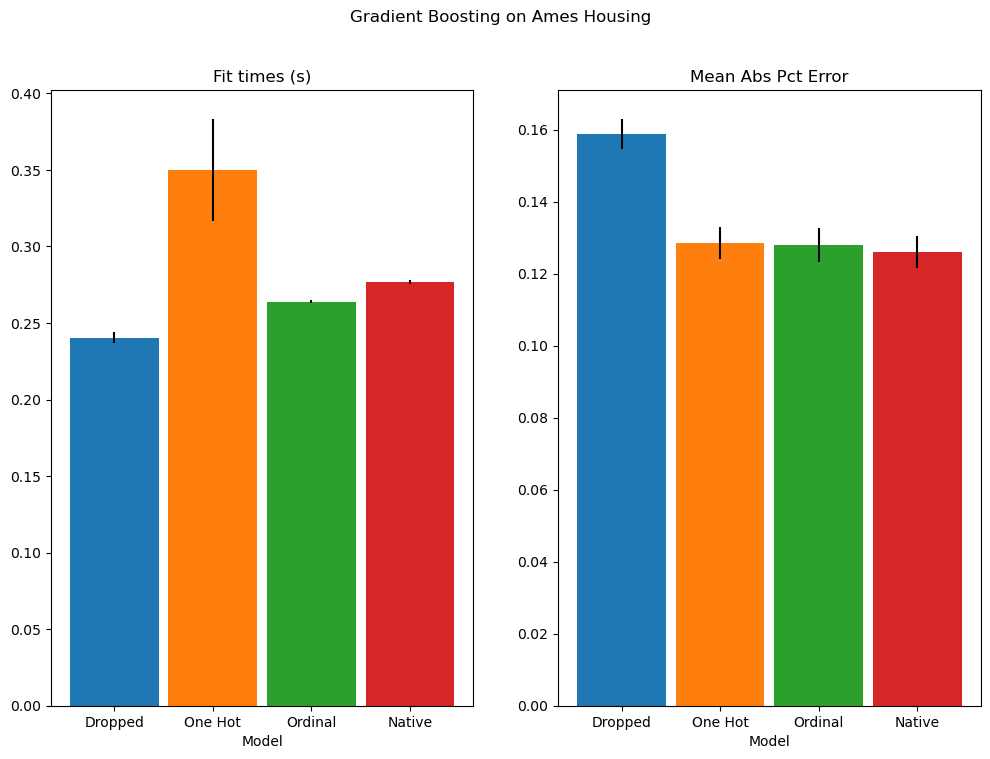

In [11]:
# compare using cross-validation. metrics: fit time & mean absolute pct error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate as CV

scoring        = "neg_mean_absolute_percentage_error"
n_cv_folds     = 3
dropped_result = CV(hist_dropped, X, y, cv=n_cv_folds, scoring=scoring)
one_hot_result = CV(hist_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
ordinal_result = CV(hist_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
native_result  = CV(hist_native, X, y, cv=n_cv_folds, scoring=scoring)

def plot_results(figure_title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    plot_info = [
        ("fit_time", "Fit times (s)", ax1, None),
        ("test_score", "Mean Abs Pct Error", ax2, None)]

    x, width = np.arange(4), 0.9
    for key, title, ax, y_limit in plot_info:
        items = [
            dropped_result[key],
            one_hot_result[key],
            ordinal_result[key],
            native_result[key]]

        mape_cv_mean = [np.mean(np.abs(item)) for item in items]
        mape_cv_std  = [np.std(item)          for item in items]

        ax.bar(
            x=x,
            height=mape_cv_mean,
            width=width,
            yerr=mape_cv_std,
            color=["C0", "C1", "C2", "C3"],
        )
        ax.set(
            xlabel="Model",
            title=title,
            xticks=x,
            xticklabels=["Dropped", "One Hot", "Ordinal", "Native"],
            ylim=y_limit,
        )
    fig.suptitle(figure_title)
plot_results("Gradient Boosting on Ames Housing")

- In general, __expect poorer predictions from one-hot-encoded data__ - especially when the tree depths or the number of nodes are limited. One-hot-encoded data needs more split points (depth) to recover an equivalent split with native handling.

- This is __also true when categories are treated as ordinal quantities__. If categories are `A..F` and the best split is `ACF - BDE` the one-hot-encoder model will need 3 split points (one per category in the left node), and the ordinal non-native model will need 4 splits: 1 split to isolate A, 1 split to isolate F, and 2 splits to isolate C from BCDE.

- Re-run the analysis with under-fitting models where we limit the total number of splits (number of trees and the depth of each tree).

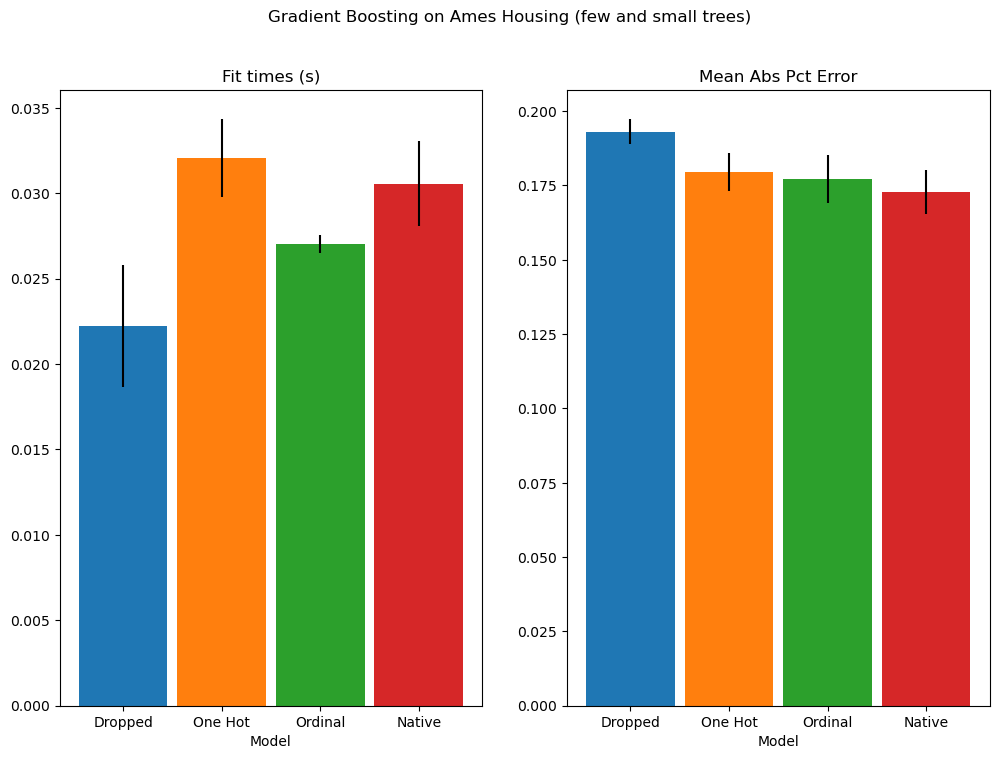

In [12]:
for pipe in (hist_dropped, hist_one_hot, hist_ordinal, hist_native):
    pipe.set_params(
        histgradientboostingregressor__max_depth=3,
        histgradientboostingregressor__max_iter=15)

dropped_result = CV(hist_dropped, X, y, cv=n_cv_folds, scoring=scoring)
one_hot_result = CV(hist_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
ordinal_result = CV(hist_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
native_result  = CV(hist_native, X, y, cv=n_cv_folds, scoring=scoring)

plot_results("Gradient Boosting on Ames Housing (few and small trees)"); plt.show()

This confirm intuition: __native category handling__ performs best when the splitting budget is constrained. The two other strategies (one-hot encoding, categories as ordinal values) lead to error values comparable to the baseline that simply dropped the categorical features.

__Monotonic constraints:__
You may already know a feature should have a positive (or negative) effect on the target value. For example, a higher credit score should increase the probability of getting approved for a loan. Monotonic constraints allow you to incorporate such prior knowledge into the model.

Specify a monotonic constraint on each feature with `monotonic_cst`. 0 = no constraint; +1 and -1 indicate a monotonic increase and monotonic decrease constraint, respectively.

### [example: gradient boosting with monotonic constraints](https://scikit-learn.org/stable/auto_examples/ensemble/plot_monotonic_constraints.html#sphx-glr-auto-examples-ensemble-plot-monotonic-constraints-py)

Build an artificial dataset where the targets are positively and negatively correlated with the first & second features respectively.
Imposing a monotonic increase or a monotonic decrease constraint during learning enables an estimator to properly follow the general trend instead of being subject to the variations.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor as HGBR
from sklearn.inspection import PartialDependenceDisplay as PDD

rng       = np.random.RandomState(0)
n_samples = 1000
f_0       = rng.rand(n_samples)
f_1       = rng.rand(n_samples)
X         = np.c_[f_0, f_1]
noise     = rng.normal(loc=0.0, scale=0.01, size=n_samples)

# y is positively correlated with f_0, and negatively correlated with f_1
y = 5 * f_0 + np.sin(10 * np.pi * f_0) - 5 * f_1 - np.cos(10 * np.pi * f_1) + noise

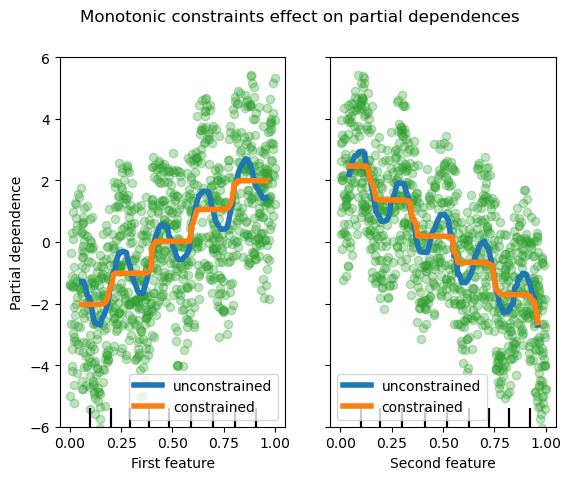

In [14]:
# fit one model with no constraints, then another with monotonic +1,-1 constraints 
gbdt_no_cst             = HGBR();                      gbdt_no_cst.fit(X, y)
gbdt_with_monotonic_cst = HGBR(monotonic_cst=[1, -1]); gbdt_with_monotonic_cst.fit(X, y)

# display partial dependence
fig, ax = plt.subplots()
disp = PDD.from_estimator(
    gbdt_no_cst,
    X,
    features=[0, 1],
    feature_names=(
        "First feature",
        "Second feature"),
    line_kw={"linewidth": 4, "label": "unconstrained", "color": "tab:blue"},
    ax=ax)

PDD.from_estimator(
    gbdt_with_monotonic_cst,
    X,
    features=[0, 1],
    line_kw={"linewidth": 4, "label": "constrained", "color": "tab:orange"},
    ax=disp.axes_)

for f_idx in (0, 1):
    disp.axes_[0, f_idx].plot(
        X[:, f_idx], y, "o", alpha=0.3, zorder=-1, color="tab:green")
    disp.axes_[0, f_idx].set_ylim(-6, 6)

plt.legend()
fig.suptitle("Monotonic constraints effect on partial dependences")
plt.show()

Conclusion: the unconstrained model captures the data oscillations; the constrained model follows the general trend and ignores the local variations.

__Interaction constraints__

Histogram gradient boosted trees are allowed to use any feature for node splits. This creates __interactions between features__, i.e. usage of different features as split along a branch. 

Sometimes, one wants to restrict the possible interactions. This can be done using `interaction_cst`, to __specify the indices of features that are allowed to interact__. 

example: with 3 total features, `interaction_cst=[{0}, {1}, {2}]` forbids all interactions. 
example: constraints [{0, 1}, {1, 2}] specifies two groups of possibly interacting features. Features 0 & 1 may interact, features 1 and 2 also. Features 0 and 2 are forbidden to interact.

Features not listed in `interaction_cst` are assigned an interaction group for themselves. With again 3 features, this means that [{0}] is equivalent to [{0}, {1, 2}].

### [example (placeholder): partial dependence plots, bike sharing dataset](https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py)

__Low-level parallelism__

HGBC and HGBR __use OpenMP for parallelization through Cython__. The following parts are parallelized:

- mapping samples from real values to integer-valued bins (finding the bin thresholds is however sequential)
- building histograms is parallelized over features
- finding the best split point at a node is parallelized over features
- during fit, mapping samples into the left and right children is parallelized over samples
- gradient and hessians computations are parallelized over samples
- predicting is parallelized over samples

__Performance__

Gradient boosting's __bottleneck__ is building the decision trees. It requires sorting the samples at each node (for each feature) so the potential gain of a split point can be computed efficiently. Splitting a single node has thus a complexity of $O(n_features * nlog(n))$ where $n$ is the number of samples at the node.

HGBC and HGBR do not require sorting the feature values and instead use histograms where samples are implicitly ordered. Building a histogram has a
complexity of $O(n)$, so the node splitting procedure has a complexity $O(n_features * n)$ - much smaller than the previous one.

The input data X needs to be binned into integer-valued bins to build a histogram. This requires sorting the feature values, but it only happens once at the beginning of the boosting process (not at each node, like in GBC and GBR).

### [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)

- Supports binary & multiclass classification
- Number of weak learners (regression trees) is controlled with `n_estimators`. Tree size is controlled with `max_depth` and `max_leaf_nodes`. 
- `learning_rate` controls overfitting via *shrinkage*. It is valued as [0.0..1.0].
- Classification with >2 classes requires induction of `n_classes` trees at each iteration. You should use `HistGradientBoostingClassifier` for datasets with large numbers of classes.

In [15]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.913

### [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

- Supports different loss functions via `loss`. The default is *least squares* (`ls`).

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor as GBR

X, y = make_friedman1(n_samples=1200, 
                      random_state=0, 
                      noise=1.0)

X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]

est = GBR(n_estimators=100, 
          learning_rate=0.1,
          max_depth=1, 
          random_state=0, 
          loss='squared_error').fit(X_train, y_train)

mean_squared_error(y_test, est.predict(X_test))

5.009154859960321

### [Example: Gradient Boosting Regressor](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html)

- Applies LS loss & 500 base learners to the diabetes dataset.
- Plots training & test error vs iteration count.

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [18]:
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13)

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'squared_error'}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3038.2382


In [19]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()

TypeError: 'str' object is not callable

### Tree Size

- The size of the regression tree base learners defines the level of variable interactions that can be captured by gradient boosting. In general, a tree of depth `h` captures interactions of order `h`.

- `max_depth=h` allows binary trees of depth `h`. They will have (at most) 2^h leaf nodes and 2^h-1 split nodes.

- `max_leaf_nodes` controls the number of leaf nodes. In this case, trees will grow using *best-first search* - nodes with the *highest improvement in impurity* will be expanded first.

- `max_leaf_nodes=k` gives comparable results to `max_depth=k-1` but is *significantly faster to train* vs a *slightly higher training error*. 

### Math Foundations

- TODO

### Loss Functions 

- Regression:
    - *least squares* (`ls`): the default choice. Initial model given by the *mean of the target values*.
    - *least absolute deviation* (`lad`): Initial model given by the *median of the target values*.
    - *huber* (`huber`): Combines LS & LAD; uses `alpha` to control outlier sensitivity.
    - *quantile* (`quantile`): For quantile regression, aka prediction intervals. Uses `0<alpha<1` to specify the quantile.
    
    
- Classification:
    - *binomial deviance* (`deviance`): Uses a *negative binomial log-likelihood* loss function for binary classification.
    - *multinomial deviance* (`deviance`): Uses a *negative multinomial log-likelihood* loss function for multiclass classification. Builds `n_classes` regression trees per iteration, which makes GBRT inefficient for large numbers of classes.
    - *exponential loss* (`exponential`): Also used by *AdaBoost*. Loss robust to mislabeled samples than `deviance`.

### Shrinkage via Learning Rate

- Regularization strategy: scales the contribution of each *weak learner* by $v$ (learning rate): $F_m(x) = F_{m-1}(x) + \nu h_m(x)$.

- The learning rate (`learning_rate`) scales the step rate in a *gradient descent* algorithm. It strongly influences `n_estimators` (the number of weak learners).

- Smaller learning rates require larger numbers of weak learners to maintain a constant training error.

- Evidence indicates smaller learning rates favor better test errors. Recommend starting with a learning rate <0.1.

### Subsampling

- *Stochastic gradient boosting* (SGB) combines GB with *bootstrap averaging (bagging)*. At each iteration, a base classifier is trained on a `subsample` (fraction, drawn without replacement, typical: 0.5) of the training data.

- Below example:
    - shows how shrinkage outperforms no-shrinkage.
    - Subsampling + shrinkage even better.
    - Subsampling without shrinkage = poor.
    

- Also: subsampling features will reduce variance. The number of subsampled features is controlled with `max_features`. Small values will significantly reduce runtimes.

- SGB allows out-of-bag (OOB) deviance estimates by finding *the improvement in deviance on the examples not included in the bootstrap*. The improvements are tracked in `oob_improvement`. This can be used, for example, for feature selection. 

- OOB estimates are usually very pessimistic. Use cross-validation instead - resort to OOB only if CV is too time-consuming.

### Interpretation with Feature Importance

- Individual decision trees can be evaluated by visualizing the tree structure. Gradient boosting models include hundreds of regression trees & cannot be easily interpreted by visual inspection. Fortunately, a number of techniques have been proposed to summarize and interpret gradient boosting models.

- Features usually do not contribute equally to a target response; in many situations the majority features are irrelevant.

- Individual decision trees perform feature selection by selecting appropriate split points. This can be used to measure the importance of each feature - *the more often a feature is used in the split points, the more important that feature is*. 

- This notion can be by *averaging the impurity-based feature importance of each tree*

- The feature importance scores of a fitted GB model can be accessed via `feature_importances_`.

- Note: this evaluation is based on *entropy*. It is distinct from *permutation_importance*, which depends on feature permutations.

In [42]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier as GBC

X, y = make_hastie_10_2(random_state=0)

clf = GBC(n_estimators=100, 
          learning_rate=1.0,
          max_depth=1, 
          random_state=0).fit(X, y)

clf.feature_importances_

array([0.10684213, 0.10461707, 0.11265447, 0.09863589, 0.09469133,
       0.10729306, 0.09163753, 0.09718194, 0.09581415, 0.09063242])

### [Example: Gradient Boosting Regularization](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regularization.html)

- illustrates effectiveness of different regularization strategies for Gradient Boosting - artificial dataset.
- loss function: binomial deviance

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import datasets

X, y = datasets.make_hastie_10_2(n_samples=12000, 
                                 random_state=1)
# map labels from {-1, 1} to {0, 1}
X               = X.astype(np.float32)
labels, y       = np.unique(y, return_inverse=True)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

original_params = {'n_estimators': 1000, 
                   'max_leaf_nodes': 4, 
                   'max_depth': None, 
                   'random_state': 2,
                   'min_samples_split': 5}

plt.figure()

for label, color, setting in [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('subsample=0.5', 'blue',
                               {'learning_rate': 1.0, 'subsample': 0.5}),
                              ('learning_rate=0.1, subsample=0.5', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.5}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2})]:
    params = dict(original_params)
    params.update(setting)

    clf = ensemble.GradientBoostingClassifier(**params).fit(X_train, y_train)
    test_deviance = np.zeros((params['n_estimators'],), 
                             dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], 
             test_deviance[::5],
            '-', color=color, label=label)

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')


AttributeError: 'GradientBoostingClassifier' object has no attribute 'loss_'

<Figure size 640x480 with 0 Axes>

### Histogram-based Gradient Boosting
- Introduced in Scikit-Learn v0.21; **much faster than standard Gradient Boosting** for datasets larger than 10K samples. **Experimental release**: API not 100% compatible with standard Gradient Boosting.
- [classification](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier) and [regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor) supported.

- Number of bins controlled with `max_bins`. Less bins = more regularization. General rule: use as many bins as possible.

- Loss function regularization is controlled with `l2_regularization`.

- Loss function options:
    - 'least_squares' & 'least_absolute_deviation' - less sensitive to outliers
    - 'poisson' - suited for counts & frequencies
    - 'binary_crossentropy' - for binary classification
    - 'categorical_crossentropy' - for multiclass classification
    - 'auto': default; loss function is chosen depending the the $y$ passed to the fit function.

- Early stopping enabled by default if #samples>10000.
    - Can be controlled by `early-stopping`, `scoring`, `validation_fraction`, `n_iter_no_change` and `tol`.
    
- Built-in missing value support - no need for standalone imputation.
    - The tree growth algo determine whether a sample with missing data should "go left" or "go right", depending on the *potential gain*.

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier as HGBC
import numpy as np

X = np.array([0, 1, 2, np.nan]).reshape(-1, 1)
y = [0, 0, 1, 1]

gbdt = HGBC(min_samples_leaf=1).fit(X, y); gbdt.predict(X)

In [ ]:
# explicitly require the feature before using
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier as HGBC
from sklearn.datasets import make_hastie_10_2

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = HGBC(max_iter=100).fit(X_train, y_train); clf.score(X_test, y_test)

- When the missingness pattern is predictive, the splits can be done on whether the feature value is missing or not:

In [44]:
X = np.array([0, np.nan, 1, 2, np.nan]).reshape(-1, 1)
y = [0, 1, 0, 0, 1]
gbdt = HGBC(min_samples_leaf=1, max_depth=2, learning_rate=1, max_iter=1).fit(X, y)
gbdt.predict(X)

array([0, 1, 0, 0, 1])

- Histogram Gradient Boosting **supports sample weights**.

In [45]:
X = [[1, 0], [1, 0], [1, 0], [0, 1]]
y = [ 0,      0,      1,      0]
w = [ 0,      0,      1,      1] # ignore 1st 2 samples by setting their weight to 0

gb = HGBC(min_samples_leaf=1)
gb.fit(X, y, sample_weight=w)

print(gb.predict([[1, 0]]))
print(gb.predict_proba([[1, 0]])[0, 1])

[1]
0.9990209190235209


- Histogram Gradient Boosting **supports categorical features**.
    - Native category support is often better than one-hot encoding, because one-hot requires more tree depth to achieve equivalent splits.
    - It is also usually better to use native category support, since the *order* of categories should not matter.
    - Done by passing a boolean mask, or a list of integer indices, to `categorical_features` to indicate which are categories:

In [46]:
gbdt = HGBC(categorical_features=[True, False])
gbdt = HGBC(categorical_features=[0])

### [Example: Histogram Gradient Boosting - Category Feature Support](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-categorical-py)
- Compares training tmies & prediction performance of a regressor with different encoding strategies:

In [47]:
# load Ames housing dataset
from sklearn.datasets import fetch_openml

X, y = fetch_openml(data_id=41211, as_frame=True, return_X_y=True)

n_categorical_features = (X.dtypes == 'category').sum()
n_numerical_features   = (X.dtypes == 'float').sum()

print(f"#samples: {X.shape[0]}")
print(f"#features: {X.shape[1]}")
print(f"#categorical features: {n_categorical_features}")
print(f"#numerical features: {n_numerical_features}")

/home/bjpcjp/.local/lib/python3.11/site-packages/sklearn/datasets/_openml.py:999: UserWarning: Version 1 of dataset ames-housing is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://api.openml.org/data/v1/download/20649135/ames-housing.arff
  warn(
/home/bjpcjp/.local/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


#samples: 2930
#features: 80
#categorical features: 46
#numerical features: 34


In [35]:
# create estimator
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor as HGBR
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

dropper = make_column_transformer(
    ('drop', make_column_selector(dtype_include='category')),
    remainder='passthrough')
hist_dropped = make_pipeline(dropper, HGBR(random_state=42))

In [36]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder as OHE

one_hot_encoder = make_column_transformer(
    (OHE(sparse=False, handle_unknown='ignore'),
     make_column_selector(dtype_include='category')),
    remainder='passthrough')

hist_one_hot = make_pipeline(one_hot_encoder, HGBR(random_state=42))

In [37]:
# ordinal encoding
from sklearn.preprocessing import OrdinalEncoder as OE
import numpy as np

ordinal_encoder = make_column_transformer(
    (OE(handle_unknown='use_encoded_value', unknown_value=np.nan),
     make_column_selector(dtype_include='category')),
    remainder='passthrough')

hist_ordinal = make_pipeline(ordinal_encoder, HGBR(random_state=42))

In [38]:
# native category support
categorical_mask = ([True]*n_categorical_features + [False]*n_numerical_features)
hist_native = make_pipeline(
    ordinal_encoder, HGBR(random_state=42, categorical_features=categorical_mask))

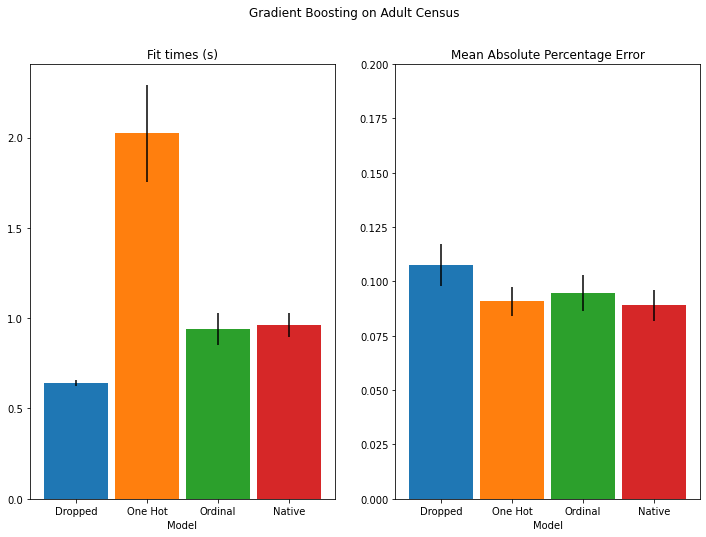

In [39]:
# compare with cross validation
from sklearn.model_selection import cross_validate as CV
import matplotlib.pyplot as plt

scoring = "neg_mean_absolute_percentage_error"
dropped_result = CV(hist_dropped, X, y, cv=3, scoring=scoring)
one_hot_result = CV(hist_one_hot, X, y, cv=3, scoring=scoring)
ordinal_result = CV(hist_ordinal, X, y, cv=3, scoring=scoring)
native_result  = CV(hist_native,  X, y, cv=3, scoring=scoring)

def plot_results(figure_title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    plot_info = [('fit_time', 'Fit times (s)', ax1, None),
                 ('test_score', 'Mean Absolute Percentage Error', ax2,
                  (0, 0.20))]

    x, width = np.arange(4), 0.9
    for key, title, ax, y_limit in plot_info:
        items = [dropped_result[key], one_hot_result[key], ordinal_result[key],
                 native_result[key]]
        ax.bar(x, [np.mean(np.abs(item)) for item in items],
               width, yerr=[np.std(item) for item in items],
               color=['C0', 'C1', 'C2', 'C3'])
        ax.set(xlabel='Model', title=title, xticks=x,
               xticklabels=["Dropped", "One Hot", "Ordinal", "Native"],
               ylim=y_limit)
    fig.suptitle(figure_title)

plot_results("Gradient Boosting on Adult Census")

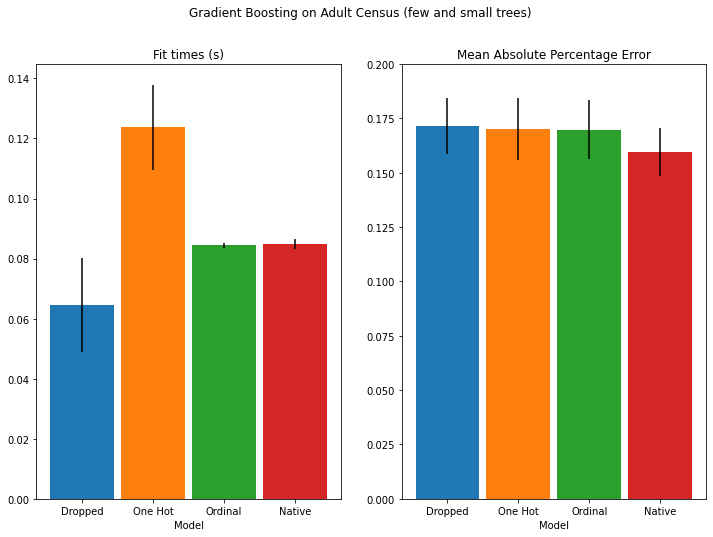

In [40]:
# limiting the #of splits 
# rerun analysis with artificially low split count by limiting #trees & tree depth
for pipe in (hist_dropped, hist_one_hot, hist_ordinal, hist_native):
    pipe.set_params(histgradientboostingregressor__max_depth=3,
                    histgradientboostingregressor__max_iter=15)

dropped_result = CV(hist_dropped, X, y, cv=3, scoring=scoring)
one_hot_result = CV(hist_one_hot, X, y, cv=3, scoring=scoring)
ordinal_result = CV(hist_ordinal, X, y, cv=3, scoring=scoring)
native_result = CV(hist_native, X, y, cv=3, scoring=scoring)

plot_results("Gradient Boosting on Adult Census (few and small trees)")
plt.show()

### Histrogram Gradient Boosting - Monotonic Constraints
- In some situations, you may already know if a given feature has a positive (or negative) effect on the target value. (For example, credit scores.) Monotonic constraints allow you to add such prior knowledge into the model.
- Definitions (where $F$ is a two-featured predictor):
    - Positive MC:$x_1 \leq x_1' \implies F(x_1, x_2) \leq F(x_1', x_2)$
    - Negative MC:$x_1 \leq x_1' \implies F(x_1, x_2) \geq F(x_1', x_2)$
- `monotonic_cst` controls the constraint. 0 = no constraint; -1 = negative, +1 = positive.
- Used in binary classification problems.

### [Example: Histogram Gradient Boosting w/ Monotonic Constraints](https://scikit-learn.org/stable/auto_examples/ensemble/plot_monotonic_constraints.html#sphx-glr-auto-examples-ensemble-plot-monotonic-constraints-py)

In [44]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor as HGBR
from sklearn.inspection import plot_partial_dependence as PPD
import numpy as np
import matplotlib.pyplot as plt

In [47]:
rng   = np.random.RandomState(0)
n     = 5000
f_0   = rng.rand(n)  # positive correlation with y
f_1   = rng.rand(n)  # negative correlation with y
X     = np.c_[f_0, f_1]
noise = rng.normal(loc=0.0, scale=0.01, size=n)
y     = (5*f_0 + np.sin(10*np.pi*f_0) -
         5*f_1 - np.cos(10*np.pi*f_1) + noise)

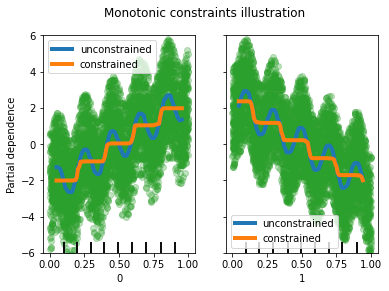

In [52]:
fig, ax = plt.subplots()

# Without any constraint
gbdt = HGBR()
gbdt.fit(X, y)
disp = PPD(gbdt, X, features=[0, 1],
           line_kw={"linewidth": 4, "label": "unconstrained", "color": "tab:blue"},
           ax=ax)

# With positive and negative constraints
gbdt = HGBR(monotonic_cst=[1, -1])
gbdt.fit(X, y)

PPD(gbdt, X, features=[0, 1],
    feature_names=(
        "First feature\nPositive constraint",
        "Second feature\nNegtive constraint",
    ),
    line_kw={"linewidth": 4, "label": "constrained", "color": "tab:orange"},
    ax=disp.axes_)

for f_idx in (0, 1):
    disp.axes_[0, f_idx].plot(
        X[:, f_idx], y, "o", alpha=0.3, zorder=-1, color="tab:green"
    )
    disp.axes_[0, f_idx].set_ylim(-6, 6)

plt.legend()
fig.suptitle("Monotonic constraints illustration")
plt.show()

### Histogram Gradient Boosting - Performance
- Gradient Boosting's bottleneck is in building the decision trees. The normal procedure *requires sorting samples at each node* so that potential gain of each split point can be computed efficiently. Splitting a single node has a computational complexity of $\mathcal{O}(n_\text{features} \times n \log(n))$ ($n$ = #samples at the node).



### Stacked Generalization
- A method for combining estimators to reduce bias. Predictions are stacked & fed to a final estimator.
- [classification](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) and [regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor) supported.
- `estimators` contains the list of stacked (in parallel) estimators.
- `final_estimator` uses the combined predictions for the final output.

In [9]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor as KNR
estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=42)),
              ('knr',   KNR(n_neighbors=20, metric='euclidean'))]

In [10]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import StackingRegressor as SR

final_estimator = GBR(n_estimators=25, 
                      subsample=0.5, 
                      min_samples_leaf=25, 
                      max_features=1,
                      random_state=42)

reg = SR(estimators=estimators, 
         final_estimator=final_estimator)

In [11]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)

from sklearn.model_selection import train_test_split as TTS

X_train, X_test, y_train, y_test = TTS(X, y, random_state=42)
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('lasso', LassoCV(random_state=42)),
                              ('knr',
                               KNeighborsRegressor(metric='euclidean',
                                                   n_neighbors=20))],
                  final_estimator=GradientBoostingRegressor(max_features=1,
                                                            min_samples_leaf=25,
                                                            n_estimators=25,
                                                            random_state=42,
                                                            subsample=0.5))

In [12]:
y_pred = reg.predict(X_test)
from sklearn.metrics import r2_score
print('R2 score: {:.2f}'.format(r2_score(y_test, y_pred)))

R2 score: 0.53


In [13]:
# getting output of stacked estimators:
reg.transform(X_test[:5])

array([[142.36214074, 138.30765507, 146.1       ],
       [179.70207217, 182.90046333, 151.75      ],
       [139.89924327, 132.47007083, 158.25      ],
       [286.94742491, 292.65164781, 225.4       ],
       [126.88190192, 124.11964797, 164.65      ]])

- During classification:
    - when using `stack_method='predict_proba', the first column is dropped if the problem is binary classification. 

In [23]:
final_layer_rfr = RFR(n_estimators=10, max_features=1, max_leaf_nodes=5,random_state=42)
final_layer_gbr = GBR(n_estimators=10, max_features=1, max_leaf_nodes=5,random_state=42)

final_layer     = SR(
    estimators=[('rf', final_layer_rfr),
                ('gbrt', final_layer_gbr)],
    final_estimator=RidgeCV()
    )

multi_layer_regressor = SR(
    estimators=[('ridge', RidgeCV()),
                ('lasso', LassoCV(random_state=42)),
                ('knr',   KNR(n_neighbors=20, metric='euclidean'))],
    final_estimator=final_layer
)
multi_layer_regressor.fit(X_train, y_train)

print('R2 score: {:.2f}'.format(multi_layer_regressor.score(X_test, y_test)))

R2 score: 0.53
